In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "anndata",
#     "dask-expr",
#     "datashader",
#     "decoupler",
#     "holoviews",
#     "hvplot",
#     "shapely",
#     "spatialpandas",
#     "scanpy",
#     "omnipath",
#     "quak",
# ]
# ///

In [2]:
%load_ext quak

# Cell type annotation from marker genes

Reproducing the deoulpeR [vignette for annotation](https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html).

In [3]:
import scanpy as sc
import decoupler as dc
import numpy as np

/Users/cvaske/Library/Caches/uv/archive-v0/UOsJ1QgygBhL2QwWLKEhh/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/cvaske/Library/Caches/uv/archive-v0/UOsJ1QgygBhL2QwWLKEhh/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/cvaske/Library/Caches/uv/archive-v0/UOsJ1QgygBhL2QwWLKEhh/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/cvaske/Library/Caches/uv/archive-v0/UOsJ1QgygBhL2QwWLKEhh/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, F

In [4]:
import anndata as ad
adata = ad.read_h5ad('adata.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 17041 × 23427
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_2.00', 'cell_type_lvl1'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dendrogram_leiden_res_0.50', 'hvg', 'leiden', 'leiden_colors', 'leiden_res_0.02', 'leiden_res_0.02_colors',

In [6]:
markers = dc.get_resource('PanglaoDB')
markers

Widget(sql='SELECT * FROM "df"')

In [7]:
# Filter by canonical_marker and human
markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

Widget(sql='SELECT * FROM "df"')

In [8]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

Running ora on mat with 17041 samples and 23427 targets for 47 sources.


  0%|          | 0/17041 [00:00<?, ?it/s]

In [9]:
adata.obsm['ora_estimate']

Widget(sql='SELECT * FROM "df"')

In [10]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 17041 × 47
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_2.00', 'cell_type_lvl1'
    uns: 'dendrogram_leiden_res_0.50', 'hvg', 'leiden', 'leiden_colors', 'leiden_res_0.02', 'leiden_res_0.02_colors', 'leiden_res_0.50', 'leiden_res_0.50_colors', 'leiden_res_2.00', 'leiden_res_2.00_colors', 'log1p', 'neighbors', 'pca', 'predicted_doublet_colors', 'rank_genes_groups', 'sample_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

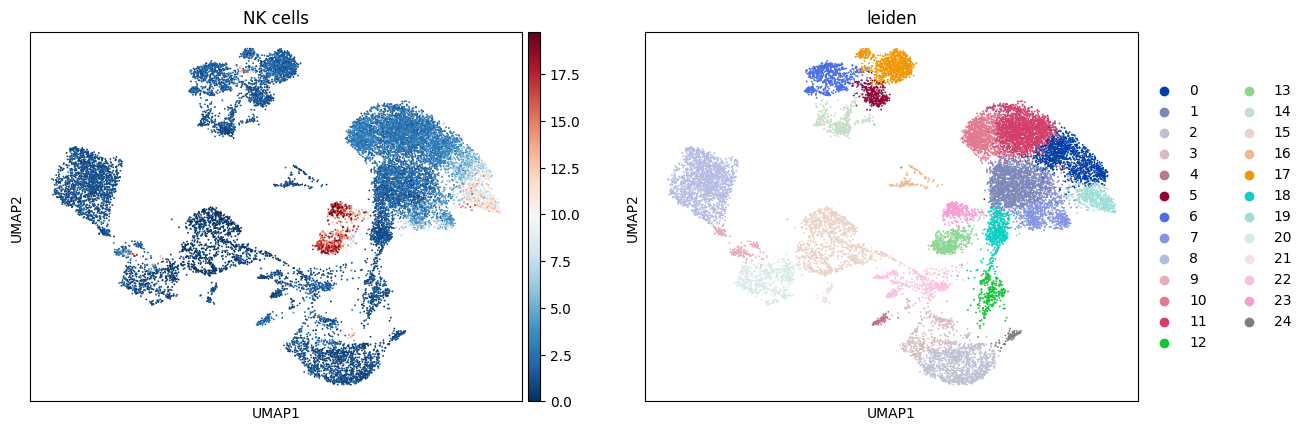

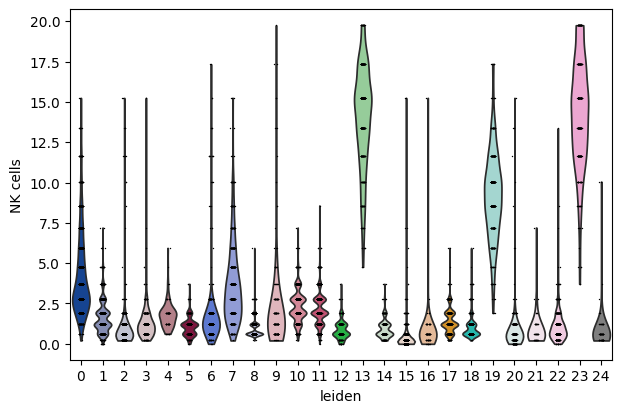

In [11]:
sc.pl.umap(acts, color=['NK cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['NK cells'], groupby='leiden')

In [12]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

Widget(sql='SELECT * FROM "df"')

In [13]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['T cells', 'Platelets', 'Fibroblasts'],
 '1': ['Basal cells', 'Mammary epithelial cells', 'Oligodendrocytes'],
 '10': ['T cells', 'Pericytes', 'Fibroblasts'],
 '11': ['T cells', 'Pericytes', 'Alpha cells'],
 '12': ['Oligodendrocyte progenitor cells', 'Monocytes', 'Macrophages'],
 '13': ['Gamma delta T cells', 'NK cells', 'Beta cells'],
 '14': ['Cholangiocytes', 'B cells', 'Keratinocytes'],
 '15': ['Erythroid-like and erythroid precursor cells',
  'Enterocytes',
  'Acinar cells'],
 '16': ['Plasma cells', 'Plasmacytoid dendritic cells', 'Gamma (PP) cells'],
 '17': ['B cells naive', 'B cells', 'Plasma cells'],
 '18': ['Basal cells', 'Mammary epithelial cells', 'Hepatic stellate cells'],
 '19': ['NK cells', 'Gamma delta T cells', 'Platelets'],
 '2': ['Macrophages', 'Dendritic cells', 'Neutrophils'],
 '20': ['Erythroid-like and erythroid precursor cells',
  'Enterocytes',
  'Acinar cells'],
 '21': ['Dendritic cells',
  'Macrophages',
  'Erythroid-like and erythroid precursor cells'],

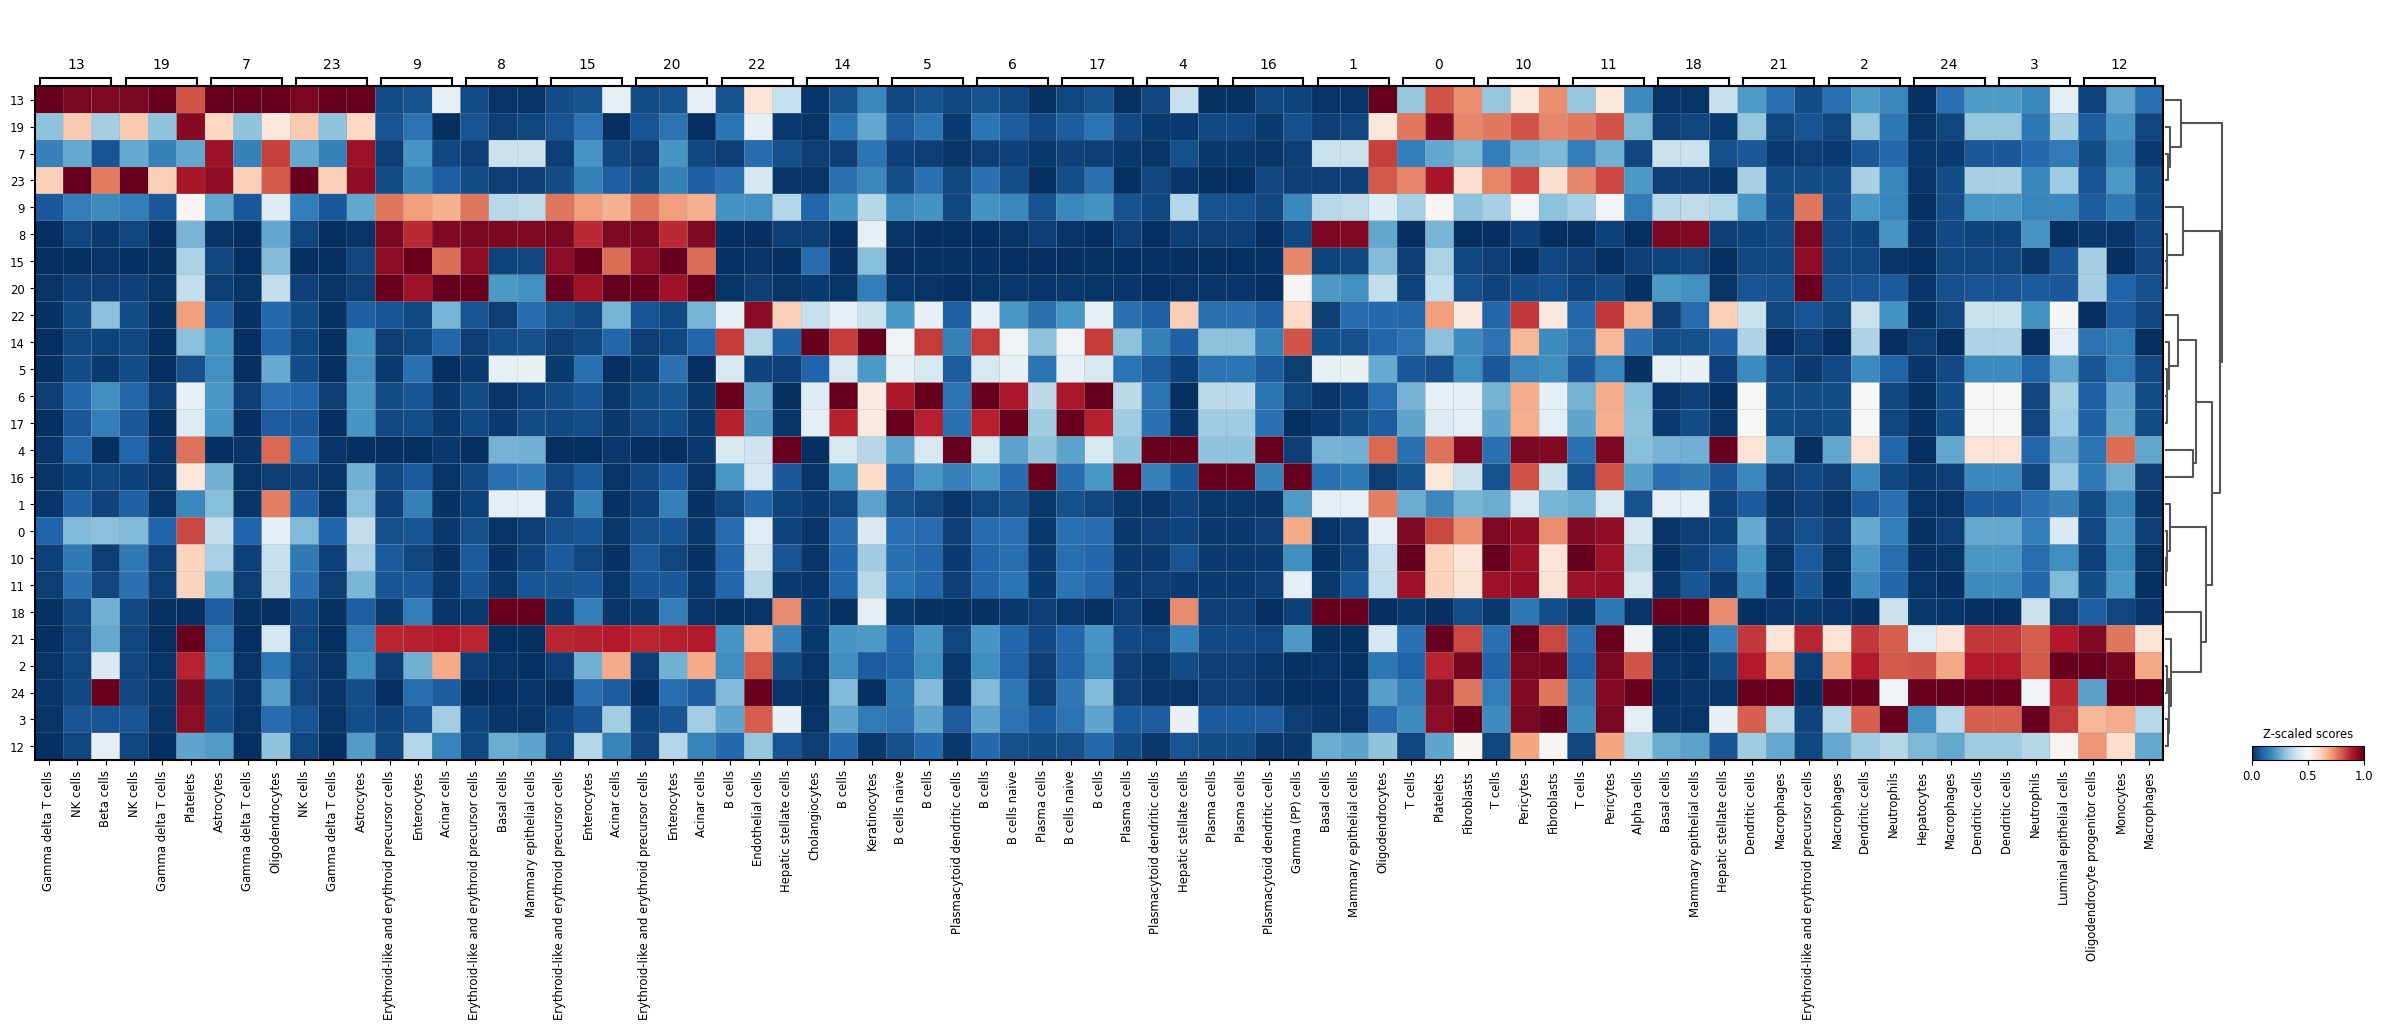

In [14]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

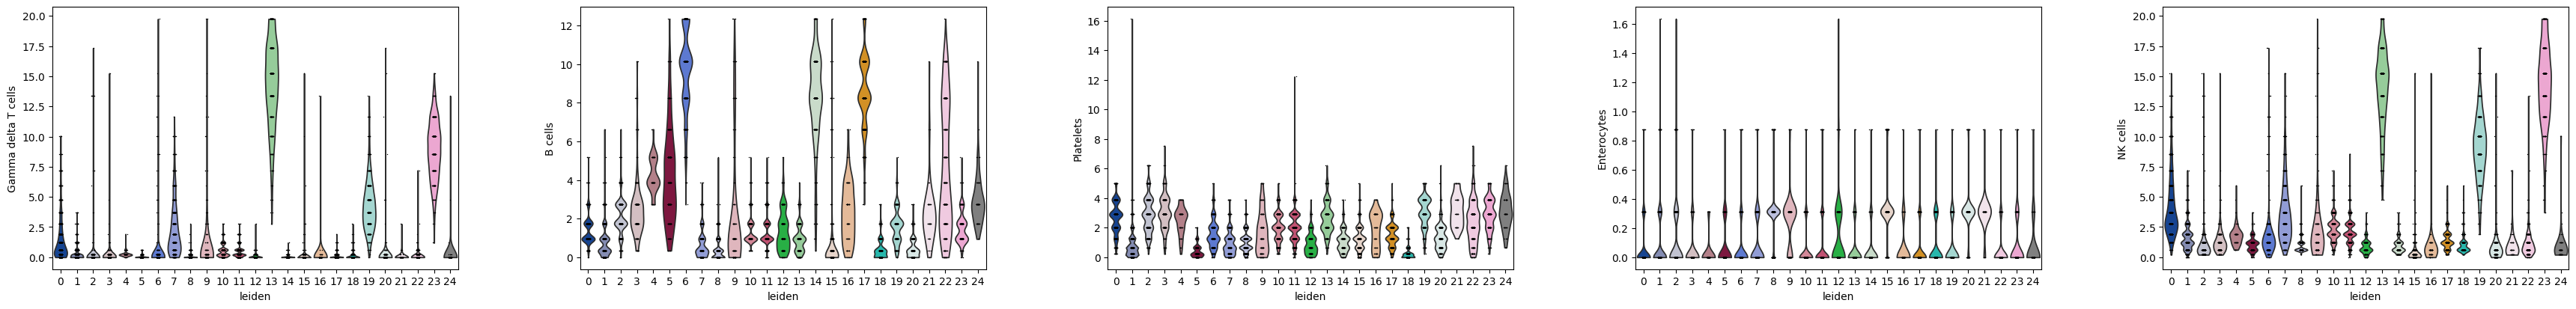

In [15]:
sc.pl.violin(acts, keys=['Gamma delta T cells', 'B cells', 'Platelets', 'Enterocytes', 'NK cells'], groupby='leiden')

In [16]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'T cells',
 '1': 'Basal cells',
 '10': 'T cells',
 '11': 'T cells',
 '12': 'Oligodendrocyte progenitor cells',
 '13': 'Gamma delta T cells',
 '14': 'Cholangiocytes',
 '15': 'Erythroid-like and erythroid precursor cells',
 '16': 'Plasma cells',
 '17': 'B cells naive',
 '18': 'Basal cells',
 '19': 'NK cells',
 '2': 'Macrophages',
 '20': 'Erythroid-like and erythroid precursor cells',
 '21': 'Dendritic cells',
 '22': 'B cells',
 '23': 'NK cells',
 '24': 'Hepatocytes',
 '3': 'Dendritic cells',
 '4': 'Plasmacytoid dendritic cells',
 '5': 'B cells naive',
 '6': 'B cells',
 '7': 'Astrocytes',
 '8': 'Erythroid-like and erythroid precursor cells',
 '9': 'Erythroid-like and erythroid precursor cells'}

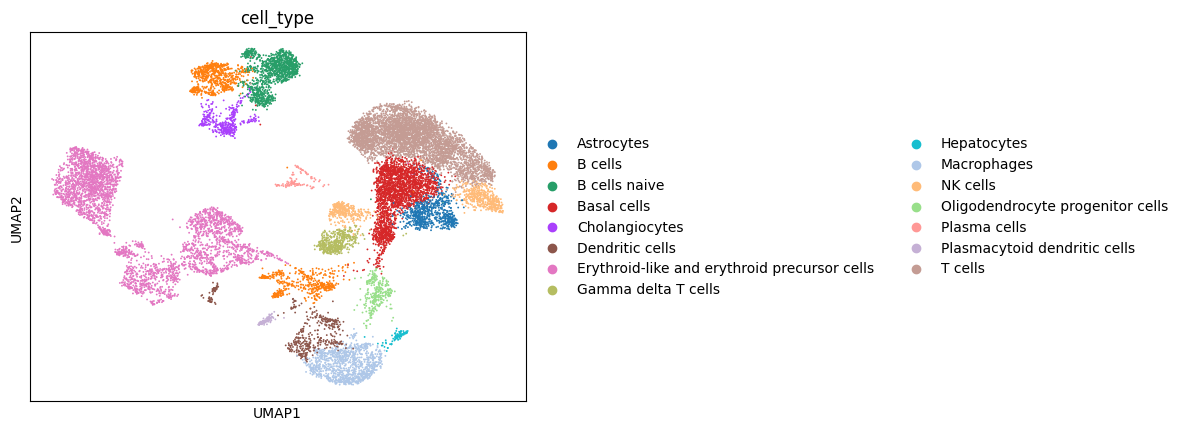

In [17]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

In [18]:
adata.write(filename='adata-annotated.h5ad')

In [19]:
adata

AnnData object with n_obs × n_vars = 17041 × 23427
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_2.00', 'cell_type_lvl1', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dendrogram_leiden_res_0.50', 'hvg', 'leiden', 'leiden_colors', 'leiden_res_0.02', 'leiden_res_

In [20]:
adata.uns.keys()

dict_keys(['dendrogram_leiden_res_0.50', 'hvg', 'leiden', 'leiden_colors', 'leiden_res_0.02', 'leiden_res_0.02_colors', 'leiden_res_0.50', 'leiden_res_0.50_colors', 'leiden_res_2.00', 'leiden_res_2.00_colors', 'log1p', 'neighbors', 'pca', 'predicted_doublet_colors', 'rank_genes_groups', 'sample_colors', 'scrublet', 'umap', 'dendrogram_leiden', 'cell_type_colors'])

In [21]:
adata.uns["leiden_res_2.00"]

{'params': {'n_iterations': -1, 'random_state': 0, 'resolution': 2.0}}

In [23]:
adata.obs['leiden_res_2.00']

AAACCCAAGGATGGCT-1     0
AAACCCAAGGCCTAGA-1     2
AAACCCAAGTGAGTGC-1     4
AAACCCACAAGAGGCT-1     5
AAACCCACATCGTGGC-1     6
                      ..
TTTGTTGAGAGTCTGG-1     6
TTTGTTGCAGACAATA-1     3
TTTGTTGCATGTTACG-1    26
TTTGTTGGTAGTCACT-1     9
TTTGTTGTCGCGCTGA-1    10
Name: leiden_res_2.00, Length: 17041, dtype: category
Categories (31, object): ['0', '1', '2', '3', ..., '27', '28', '29', '30']

In [24]:
adata.obsm['ora_estimate']

Widget(sql='SELECT * FROM "df"')

In [25]:
adata.obs['cell_type']

AAACCCAAGGATGGCT-1                                         T cells
AAACCCAAGGCCTAGA-1                                     Macrophages
AAACCCAAGTGAGTGC-1                                   B cells naive
AAACCCACAAGAGGCT-1                    Plasmacytoid dendritic cells
AAACCCACATCGTGGC-1                                      Astrocytes
                                          ...                     
TTTGTTGAGAGTCTGG-1                                      Astrocytes
TTTGTTGCAGACAATA-1                                 Dendritic cells
TTTGTTGCATGTTACG-1    Erythroid-like and erythroid precursor cells
TTTGTTGGTAGTCACT-1                                     Basal cells
TTTGTTGTCGCGCTGA-1                                         T cells
Name: cell_type, Length: 17041, dtype: category
Categories (15, object): ['Astrocytes', 'B cells', 'B cells naive', 'Basal cells', ..., 'Oligodendrocyte progenitor cells', 'Plasma cells', 'Plasmacytoid dendritic cells', 'T cells']

In [26]:
adata.obs['cell_type_lvl1']

AAACCCAAGGATGGCT-1    Lymphocytes
AAACCCAAGGCCTAGA-1      Monocytes
AAACCCAAGTGAGTGC-1      Erythroid
AAACCCACAAGAGGCT-1    Lymphocytes
AAACCCACATCGTGGC-1    Lymphocytes
                         ...     
TTTGTTGAGAGTCTGG-1    Lymphocytes
TTTGTTGCAGACAATA-1      Monocytes
TTTGTTGCATGTTACG-1            NaN
TTTGTTGGTAGTCACT-1    Lymphocytes
TTTGTTGTCGCGCTGA-1    Lymphocytes
Name: cell_type_lvl1, Length: 17041, dtype: category
Categories (4, object): ['B Cells', 'Erythroid', 'Lymphocytes', 'Monocytes']

In [30]:
adata.obs['cell_type_lvl1'].dtype.name

'category'

In [37]:
all([x.isdigit() for x in adata.obs['leiden_res_2.00'].cat.categories + ['10e']])

False

In [38]:
print("12986".isdigit())
print("12986e".isdigit())
print("e12986".isdigit())

True
False
False


In [43]:
adata.obs['cell_type_lvl1'].cat.categories

Index(['B Cells', 'Erythroid', 'Lymphocytes', 'Monocytes'], dtype='object')